In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = SimpleCNN().to("cuda")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
def train_model(model, trainloader, optimizer, criterion, device):
    for epoch in range(3):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 1000 == 999:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0

train_model(model, trainloader, optimizer, criterion, "cuda")

# Adversarial Attack Functions
def fgsm_attack(image, epsilon, data_grad, targeted=False):
    sign_data_grad = data_grad.sign()
    perturbed_image = image - epsilon * sign_data_grad if targeted else image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def pgd_attack(image, epsilon, labels, targeted=False, alpha=0.01, num_steps=40):
    perturbed_image = image.clone().detach().requires_grad_(True)
    for _ in range(num_steps):
        output = model(perturbed_image)
        loss = -criterion(output, labels) if targeted else criterion(output, labels)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_image = perturbed_image + alpha * perturbed_image.grad.sign()
            perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon).clamp(0, 1)
        perturbed_image = perturbed_image.detach().requires_grad_(True)
    return perturbed_image

def evaluate_model(model, dataloader, epsilon_values, attack_type, targeted=False):
    accuracies = []


    correct_clean = 0
    total_clean = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs_clean = model(images)
            _, predicted_clean = torch.max(outputs_clean.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted_clean == labels).sum().item()
    clean_accuracy = correct_clean / total_clean
    accuracies.append(clean_accuracy)

    # Perform adversarial attacks
    for epsilon in epsilon_values:
        correct_adv = 0
        total_adv = 0
        for images, labels in dataloader:
            images, labels = images.to("cuda"), labels.to("cuda")
            images.requires_grad = True

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()

            if attack_type == "FGSM":
                perturbed_images = fgsm_attack(images, epsilon, images.grad, targeted=targeted)
            elif attack_type == "PGD":
                perturbed_images = pgd_attack(images, epsilon, labels, targeted=targeted)

            perturbed_outputs = model(perturbed_images)
            _, perturbed_predicted = torch.max(perturbed_outputs.data, 1)

            total_adv += labels.size(0)
            correct_adv += (perturbed_predicted == labels).sum().item()

        adversarial_accuracy = correct_adv / total_adv
        accuracies.append(adversarial_accuracy)

    return accuracies

# Print Clean and Adversarial Accuracies
def print_accuracies_header(epsilon_values):
    header = "{:<20} {:<15}".format("Attack Type", "Clean Accuracy")
    for epsilon in epsilon_values:
        header += " {:<15}".format(f"Epsilon={epsilon}")
    print(header)

def print_accuracies_row(attack_type, accuracies):
    row = "{:<20}".format(attack_type)
    for accuracy in accuracies:
        row += " {:<15.4f}".format(accuracy)
    print(row)

# Example usage
epsilon_values = [0.05, 0.2, 0.3]
attack_types = ["FGSM - Untargeted", "FGSM - Targeted", "PGD - Untargeted", "PGD - Targeted"]

print_accuracies_header(epsilon_values)
for attack_type in attack_types:
    targeted = "Targeted" in attack_type
    accuracies = evaluate_model(model, testloader, epsilon_values, attack_type.split(' ')[0], targeted=targeted)
    print_accuracies_row(attack_type, accuracies)


100%|██████████| 9912422/9912422 [00:00<00:00, 133938916.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7312307.97it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42308086.73it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16829089.02it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Clean and Adversarial Accuracies: [0.9652, 0.6517, 0.4833, 0.3616]


Attack Type          Clean Accuracy  Epsilon=0.05    Epsilon=0.1     Epsilon=0.2    
FGSM - Untargeted    0.9652          0.6517          0.6010          0.4833         


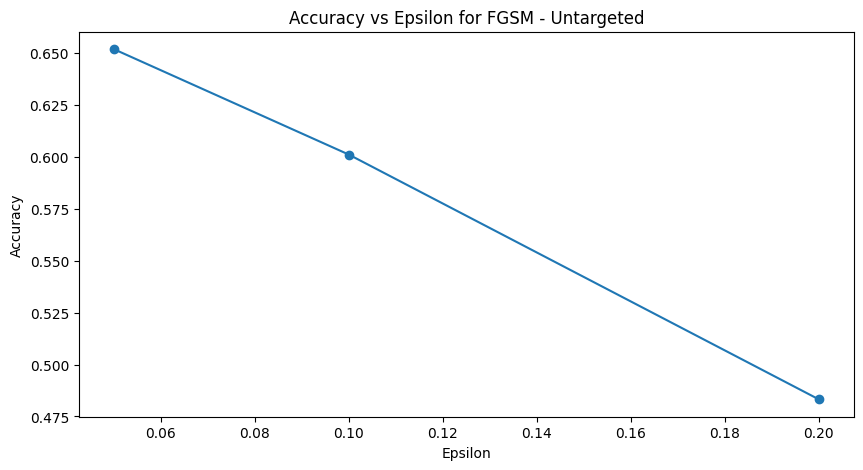

FGSM - Targeted      0.9652          0.7336          0.7608          0.7971         


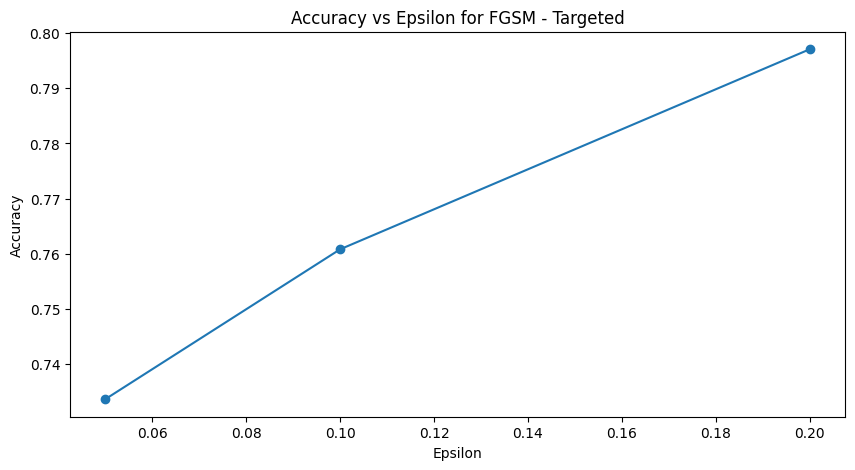

PGD - Untargeted     0.9652          0.6285          0.5495          0.3775         


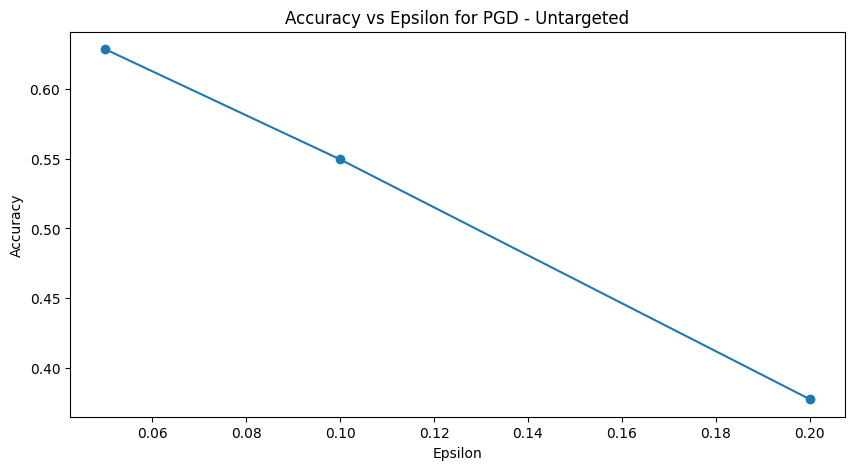

PGD - Targeted       0.9652          0.7550          0.7992          0.8649         


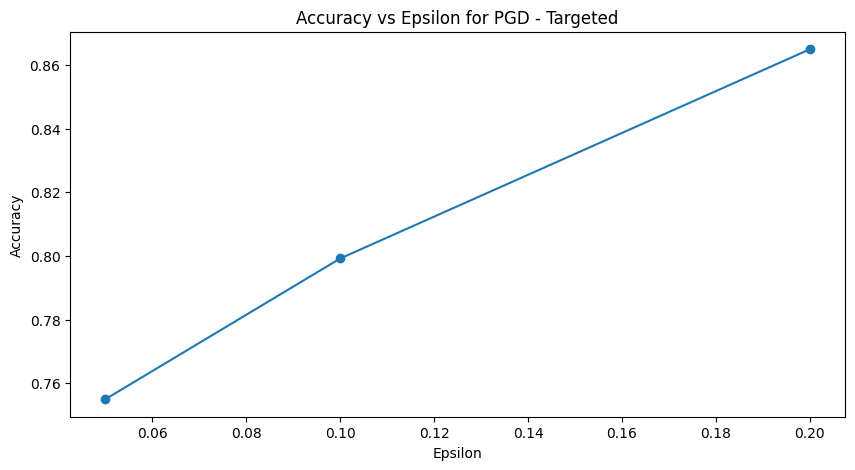

In [3]:
import matplotlib.pyplot as plt

# Print Clean and Adversarial Accuracies with Graph
def print_accuracies_header(epsilon_values):
    header = "{:<20} {:<15}".format("Attack Type", "Clean Accuracy")
    for epsilon in epsilon_values:
        header += " {:<15}".format(f"Epsilon={epsilon}")
    print(header)

def print_accuracies_row(attack_type, accuracies, epsilon_values):
    row = "{:<20}".format(attack_type)
    for accuracy in accuracies:
        row += " {:<15.4f}".format(accuracy)
    print(row)

    # Plot accuracy vs epsilon graph
    plt.figure(figsize=(10, 5))
    plt.plot(epsilon_values, accuracies[1:], marker='o')
    plt.title(f"Accuracy vs Epsilon for {attack_type}")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

# Example usage
epsilon_values = [0.05, 0.1, 0.2]
attack_types = ["FGSM - Untargeted", "FGSM - Targeted", "PGD - Untargeted", "PGD - Targeted"]

print_accuracies_header(epsilon_values)
for attack_type in attack_types:
    targeted = "Targeted" in attack_type
    accuracies = evaluate_model(model, testloader, epsilon_values, attack_type.split(' ')[0], targeted=targeted)
    print_accuracies_row(attack_type, accuracies, epsilon_values)


Attack type 'FGSM - Untargeted' not recognized.


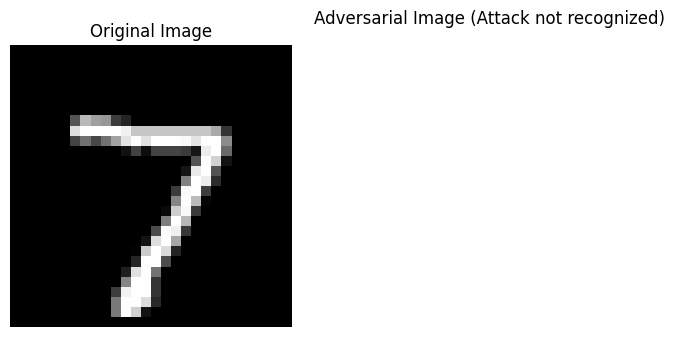

Attack type 'PGD - Untargeted' not recognized.


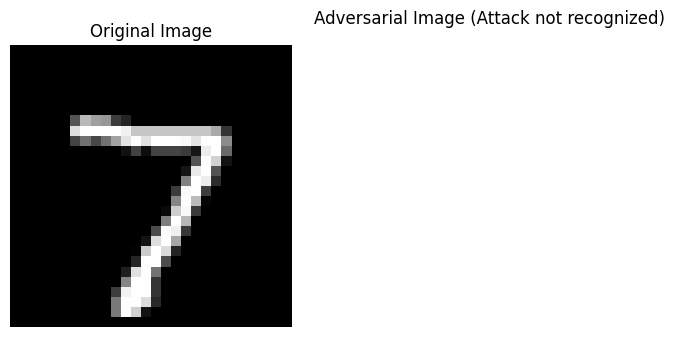

In [13]:
def display_images(original, adversarial, epsilon, attack_type):
    original_image = original[0][0].cpu().detach().numpy()
    adversarial_image = adversarial[0][0].cpu().detach().numpy() if adversarial is not None else None

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    if adversarial_image is not None:
        plt.title(f"Adversarial Image (Epsilon={epsilon}, {attack_type})")
        plt.imshow(adversarial_image, cmap='gray')
    else:
        plt.title("Adversarial Image (Attack not recognized)")
    plt.axis('off')

    plt.show()

# Function to get an example image and perform adversarial attack
def get_adversarial_example(model, dataloader, epsilon, attack_type, targeted=False):
    for images, labels in dataloader:
        images, labels = images.to("cuda"), labels.to("cuda")
        images.requires_grad = True

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        if attack_type == "FGSM":
            perturbed_images = fgsm_attack(images, epsilon, images.grad, targeted=targeted)
        elif attack_type == "PGD":
            perturbed_images = pgd_attack(images, epsilon, labels, targeted=targeted)
        else:
            # Handle unrecognized attack type gracefully
            print(f"Attack type '{attack_type}' not recognized.")
            display_images(images, None, epsilon, attack_type)
            return None, None, None, None

        perturbed_outputs = model(perturbed_images)
        _, perturbed_predicted = torch.max(perturbed_outputs.data, 1)

        # Display original and adversarial images
        display_images(images, perturbed_images, epsilon, attack_type)

        return images, perturbed_images, labels, perturbed_predicted

# Display adversarial examples for FGSM and PGD attacks
epsilon_fgsm = 0.1
epsilon_pgd = 0.1
attack_type_fgsm = "FGSM - Untargeted"
attack_type_pgd = "PGD - Untargeted"

original_fgsm, adversarial_fgsm, true_labels_fgsm, predicted_labels_fgsm = get_adversarial_example(model, testloader, epsilon_fgsm, attack_type_fgsm)
original_pgd, adversarial_pgd, true_labels_pgd, predicted_labels_pgd = get_adversarial_example(model, testloader, epsilon_pgd, attack_type_pgd)